# Credit Card Fraud Detection Project

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. 

The dataset contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, the owners of the dataset cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

Feature **'Time'** contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature **'Amount'** is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

- Link to the dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [1]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [40]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import class_weight
from imblearn.under_sampling import RandomUnderSampler
import shap

In [3]:
# Setting params for plots
from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

## Obtaining

In [4]:
# Loading in dataset into a dataframe
df = pd.read_csv('../../../data/creditcard.csv')

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploring

In [6]:
# Viewing the number of columns and rows within the dataset
print(f"Credit Card Fraud Detection Dataset:\nrows: {df.shape[0]}\ncolumns: {df.shape[1]}")

Credit Card Fraud Detection Dataset:
rows: 284807
columns: 31


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

At first glance, it seems we do not have any rows with null information. 

In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
# We have rows where Amount is equal to 0. Let's drop these from the df
print(f"Number of rows where Amount is $0.00: \n{len(df[df['Amount'] == 0])}")

Number of rows where Amount is $0.00: 
1825


In [10]:
# Dropping rows where Amount is equal to 0
df = df[df['Amount'] > 0]

In [11]:
fraud = df['Class'].value_counts()[1]
true = df['Class'].value_counts()[0]
print(f"Percentage of fraudulent transactions: {round(fraud/len(df) * 100, 3)}%\n"
      f"Percentage of non-fraudulent transactions: {round(true/len(df) * 100, 3)}%")

Percentage of fraudulent transactions: 0.164%
Percentage of non-fraudulent transactions: 99.836%


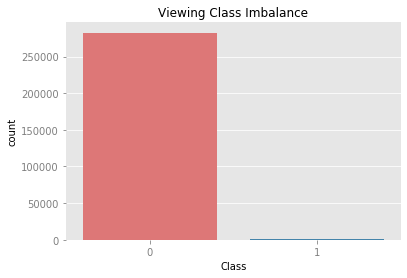

In [12]:
ax = sns.countplot(x='Class', data=df)
ax.set_title('Viewing Class Imbalance');

There is extreme class imbalance between the two classes. Remember that the number of fraudulent transactions within this dataset is 492, which accounts for only 0.173% of all the data.

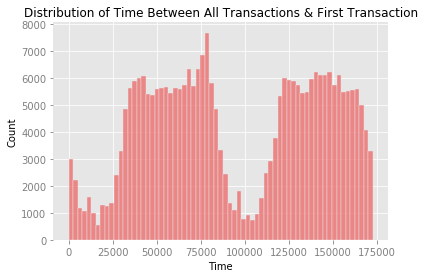

In [13]:
ax = sns.histplot(data=df, x='Time')
ax.set_title('Distribution of Time Between All Transactions & First Transaction');

In [14]:
df['Time'].describe()

count    282982.000000
mean      94848.963528
std       47482.459589
min           0.000000
25%       54251.250000
50%       84707.500000
75%      139363.750000
max      172792.000000
Name: Time, dtype: float64

In [15]:
n_sec_per_day = 86400

df['Time'].max() / n_sec_per_day

1.9999074074074075

We see that the time column contains around 285,000 transactions by looking at the 'count' row. By taking the maximum value of the time column and dividing it by the number of seconds in a day, we can see that all transactions within this dataset occurred within 2 days.

#### Creating an 'Hours' column

We are going to create a new column called **'Hours'** that tells us what hour the transaction happened in military time.

In [16]:
def make_hours(num):
    val = round((num / n_sec_per_day * 24)) 
    if val > 24:
        val = val - 24
    return val

In [17]:
apply_hours = df['Time'].apply(make_hours)
df['Hours'] = apply_hours

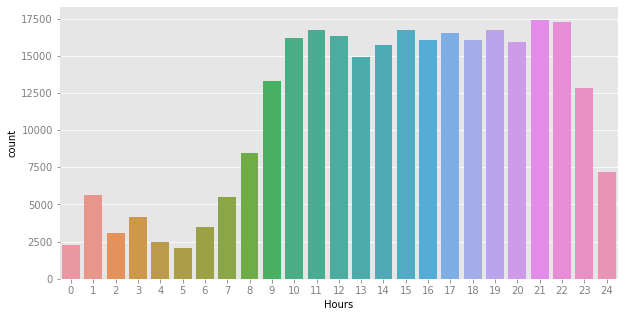

In [18]:
plt.figure(figsize=(10,5))
sns.countplot(x='Hours', data=df);

In [19]:
df['Hours'].value_counts()

21    17403
22    17240
19    16704
11    16703
15    16702
17    16551
12    16353
10    16208
16    16048
18    16023
20    15915
14    15738
13    14936
9     13296
23    12830
8      8470
24     7168
1      5661
7      5506
3      4169
6      3458
2      3089
4      2485
0      2247
5      2079
Name: Hours, dtype: int64

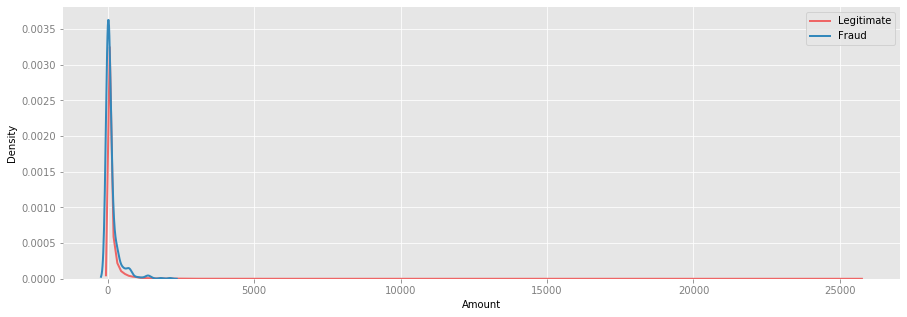

In [20]:
# The amount column is not a normal distribution
plt.figure(figsize=(15,5))
sns.kdeplot(df.loc[df['Class']==0, 'Amount'], label='Legitimate')
sns.kdeplot(df.loc[df['Class']==1, 'Amount'], label='Fraud')
plt.legend();

We notice there are some major outliers in the 'Amount' column. It seems like the majority of the fraudulent charges are below $3000.00 charges.

In [21]:
df['Amount'].describe()

count    282982.000000
mean         88.919401
std         250.824374
min           0.010000
25%           5.990000
50%          22.490000
75%          78.000000
max       25691.160000
Name: Amount, dtype: float64

In [22]:
# Dropping unecessary columns
df.drop(columns=['Time'], inplace=True)

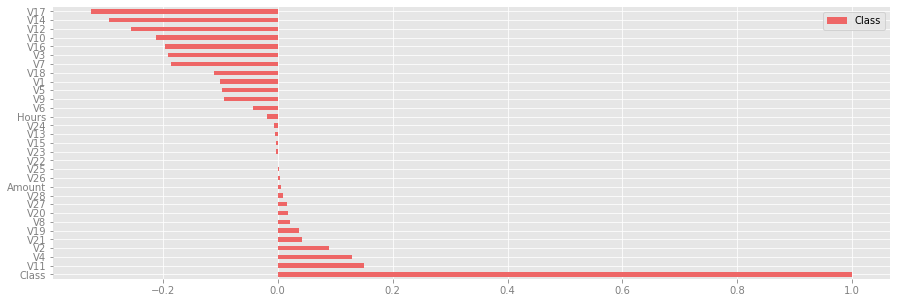

In [23]:
df_importance = pd.DataFrame(df.corr()['Class']).\
                sort_values(by='Class',ascending=False)
df_importance.plot(kind='barh', figsize=(15,5));

### Undersampling the data

In [24]:
X = df.drop(columns='Class')
Y = df['Class']

In [25]:
# Undersampling the data
undersample = RandomUnderSampler(sampling_strategy=0.5)
feats, labels = undersample.fit_resample(X=X, y=Y)

### Creating train and test sets

In [26]:
# Creating a train and test set
X_train, X_test, y_train, y_test = train_test_split(feats, labels, random_state=42)

In [27]:
X_train.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Hours'],
      dtype='object')

### Dummy Classifier

In [28]:
dummy = DummyClassifier(strategy='stratified')

In [29]:
dummy.fit(X_train, y_train)
y_pred = dummy.predict(y_test)

Recall Score: 0.3247863247863248
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       232
           1       0.35      0.32      0.34       117

    accuracy                           0.57       349
   macro avg       0.51      0.51      0.51       349
weighted avg       0.56      0.57      0.57       349



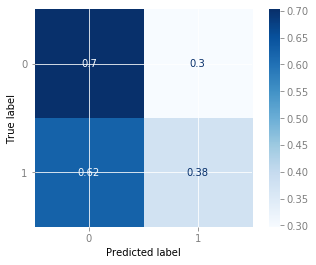

In [30]:
# Classification report
print(f"Recall Score: {metrics.recall_score(y_test, y_pred)}")
print(metrics.classification_report(y_test, y_pred))

plot_confusion_matrix(dummy, X_test,y_test,normalize='true',cmap='Blues');


The recall score for the dummy classifier is around 40% when it comes to correctly identifying fraudulent charges. The dummy model tends to be guessing more towards the non-fraudulent class. Let's see if we can improve the recall score through Logistic Regression.

### Adding Class Weights

In [42]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), 
                                                  y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Our class weights:\n{class_weights_dict}")

Our class weights:
{0: 0.7492836676217765, 1: 1.5028735632183907}


## Logistic Regression

In [43]:
# Creating and fitting the model on the train set
model = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', 
                          class_weight=class_weights_dict)
fit_model = model.fit(X_train, y_train)

In [44]:
y_hat_test = fit_model.predict(X_test)
y_hat_train = fit_model.predict(X_train)

In [45]:
print(f"Train accuracy score: {metrics.balanced_accuracy_score(y_train, y_hat_train)}")
print(f"Test accuracy score: {metrics.balanced_accuracy_score(y_test, y_hat_test)}")

Train accuracy score: 0.9590743668280473
Test accuracy score: 0.9335580607132331


In [46]:
print(f"Train recall score: {metrics.recall_score(y_train, y_hat_train)}")
print(f"Test recall score: {metrics.recall_score(y_test, y_hat_test)}")

Train recall score: 0.9339080459770115
Test recall score: 0.9145299145299145


In [47]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95       232
           1       0.91      0.91      0.91       117

    accuracy                           0.94       349
   macro avg       0.93      0.93      0.93       349
weighted avg       0.94      0.94      0.94       349



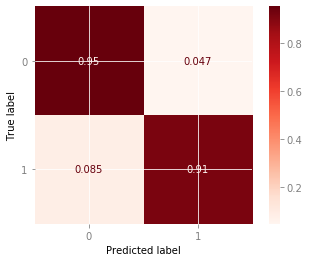

In [48]:
plot_confusion_matrix(fit_model, X_test,y_test,normalize='true',cmap='Reds');

<Figure size 504x504 with 0 Axes>

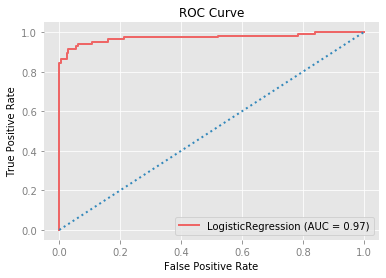

In [49]:
## Plot Roc Curve on second ax
plt.figure(figsize=(7, 7))
roc_plot = plot_roc_curve(model, X_test, y_test)
plt.legend()
# Threshold line
plt.plot([0,1],[0,1],ls=':')
plt.title('ROC Curve')
plt.show()

## Decision Tree Classifier

## Citations

1. Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015


2. Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon


3. Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE


4. Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)


5. Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier


6. Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing


7. Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019


8. Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019